# Compare Results With and Without Inter-room Air Movement

Here we run two simulations in our simple office. In the first, we only include air exchange between the rooms and the HVAC system, and in the second, we also include air exchange between adjacent rooms.

We run the the simulations until our usual stopping rules apply.

## Imports

In [1]:
import os
from itertools import repeat
from multiprocessing import Pool
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from apsrm import PCRTest, Person, Box
from apsrm.config import POOL_NCORES, DEFAULT_STRAIN
from apsrm.ext.multiprocessing import ProcessSeeder
from apsrm.ext.simulation import (
    create_pathogen,
    run_simulation,
    generate_means_tables,
    plot_histograms)
from utils import (
    BOX_TYPE,
    create_workplace,
    create_emissions_calculator)

OUTPUT_BASE_DIR = '../../outputs/office'
OUTPUT_BASE_DIR = OUTPUT_BASE_DIR if os.path.exists(OUTPUT_BASE_DIR) else '.'
OUTPUT_PREFIX = 'vent_comp'
def opath(p):
    return os.path.join(OUTPUT_BASE_DIR, '{}_{}'.format(OUTPUT_PREFIX, p))

process_seeder = ProcessSeeder()

def run_job(workplace, runner, R, intervention_name):
    process_seeder.reset()
    with Pool(POOL_NCORES, initializer=process_seeder) as pool:
        work = pool.imap_unordered(runner, repeat(workplace, R))
        return pd.DataFrame(tqdm(work, total=R)).assign(intervention=intervention_name)

def runner(workplace):
    workplace.reset(full=True)
    return run_simulation(workplace, pathogen, emissions_calculator, pcrtest)

In [2]:
R = 10000
n_workers=40
external_acph = 1.
hvac_acph = 7.
open_plan_space_per_worker = 7.

pathogen = create_pathogen(DEFAULT_STRAIN)
emissions_calculator = create_emissions_calculator(pathogen)
pcrtest = PCRTest()

workplace = create_workplace(
    n_workers = n_workers,
    open_plan_area_per_worker = open_plan_space_per_worker)
hvac_box = Box(1., BOX_TYPE.HVAC, 0, name='hvac') 
workplace.add_box(hvac_box)

## Setup HVAC System

Create the ventilation matix for the HVAC system

In [3]:
exchange_volumes = [hvac_acph * b.volume for b in workplace.boxes]
exchange_volumes[hvac_box.box_index] = 0.

hvac_only = np.zeros((len(workplace.boxes), len(workplace.boxes)))
hvac_only[hvac_box.box_index, :] = hvac_only[:,hvac_box.box_index] = exchange_volumes

total_external_ventilation = external_acph * sum(b.volume for b in workplace.boxes if b.use != BOX_TYPE.HVAC)
external_ventilation = np.zeros(len(workplace.boxes))
external_ventilation[hvac_box.box_index] = total_external_ventilation

Create the ventilation matrix for the rooms

In [4]:
rooms = np.array([
    [   0.  ,    0.  ,    0.  ,  270.  ,    0.  , 0.],
    [   0.  ,    0.  ,    0.  ,   75.  ,    0.  , 0.],
    [   0.  ,    0.  ,    0.  ,  371.25,    0.  , 0.],
    [ 270.  ,   75.  ,  371.25,    0.  , 1305.  , 0.],
    [   0.  ,    0.  ,    0.  , 1305.  ,    0.  , 0.],
    [   0.  ,    0.  ,    0.  ,    0.  ,    0.  , 0.]])
hvac_and_rooms = hvac_only + rooms

## Simulations

### HVAC to Mimic No HVAC

In [5]:
workplace.set_ventilation_properties(
    external_ventilation = np.array([external_acph * b.volume for b in workplace.boxes]),
    force_standard_hvac_system = True)
results_zero_hvac = run_job(workplace, runner, R, 'No HVAC')

  0%|          | 0/1000 [00:00<?, ?it/s]

### HVAC Only

Air is only exchanged between the boxes and the HVAC system (i.e., no air moves between the rooms).

In [6]:
workplace.set_ventilation_properties(
    hvac_only,
    external_ventilation = external_ventilation)
results_hvac_only = run_job(workplace, runner, R, 'HVAC Only')

  0%|          | 0/1000 [00:00<?, ?it/s]

### HVAC and Connected Boxes

Air is exchanged between the boxes and the HVAC system, and directly between the boxes.

In [7]:
workplace.set_ventilation_properties(
    hvac_and_rooms,
    external_ventilation = external_ventilation)
results_hvac_and_rooms = run_job(workplace, runner, R, 'HVAC and Rooms')

  0%|          | 0/1000 [00:00<?, ?it/s]

### HVAC Only at Half Rate

In [12]:
workplace.set_ventilation_properties(
    .5 * hvac_only + rooms,
    external_ventilation = external_ventilation)
results_hvac_half_rate = run_job(workplace, runner, R, '50% HVAC and Rooms')

  0%|          | 0/1000 [00:00<?, ?it/s]

## Plots and Tables

In [13]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['../fnt']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'Palatino'

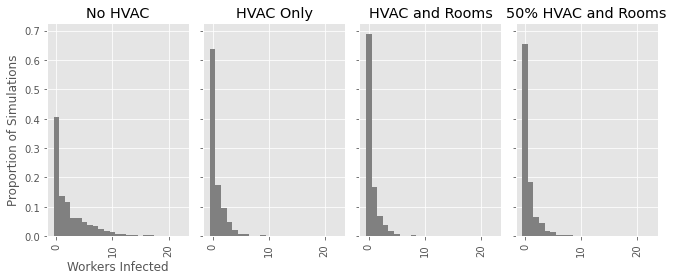

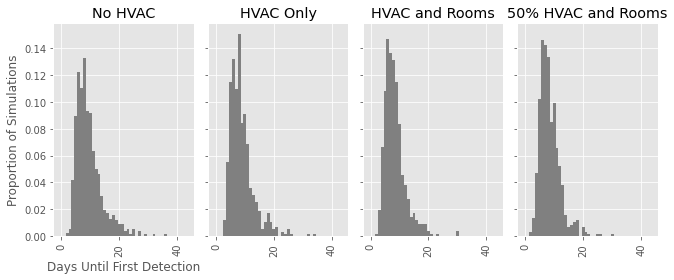

In [14]:
all_results = (
    results_zero_hvac,
    results_hvac_only,
    results_hvac_and_rooms,
    results_hvac_half_rate)
infection_counts = pd.concat(all_results)
dt = CategoricalDtype(categories=['No HVAC', 'HVAC Only', 'HVAC and Rooms', '50% HVAC and Rooms'], ordered=True)
infection_counts['intervention'] = infection_counts['intervention'].astype(dt)
plot_histograms(infection_counts, OUTPUT_BASE_DIR, OUTPUT_PREFIX)

In [15]:
means, means_latex = generate_means_tables(
    infection_counts, R,
    caption = r'Average number of workers infected and average first period in which a case is detected for each HVAC configuration. The averages are taken over the simulations used to generate the histograms shown in Figure~\ref{fig:vent_comp_number_infected}.',
    label = 'tab:vent_comp_means',
    baseline_column = 'No HVAC')

with open(opath('means.tex'), 'w') as outf: outf.write(means_latex)
print(means)

                    period_finished  number_infected  any_detected  \
intervention                                                         
No HVAC                      12.293            2.607         0.760   
HVAC Only                    13.948            0.738         0.583   
HVAC and Rooms               13.695            0.604         0.573   
50% HVAC and Rooms           13.799            0.714         0.576   

                    relative_number_infected  
intervention                                  
No HVAC                             0.000000  
HVAC Only                           0.716916  
HVAC and Rooms                      0.768316  
50% HVAC and Rooms                  0.726122  
